# Load the needed modules

First load the needed modules that we'll be using and make sure the packages are found. If the packages were not found, be sure that you activated your `cvpy` environment with 
```bash
$ source activate cvpy
```
before starting the Jupyter notebook server. If the environment is activated and the modules were still not loaded, please double-check the installation instructions in the [GitHub README.md](https://github.com/alkasm/cvpy).

In [26]:
# manipulation
import numpy as np
import cv2

# displaying images
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Test loading and displaying an image
OpenCV's graphical and displaying abilities are quite limited, so we'll use `plt.imshow()` from `matplotlib` to display images in-line. We'll also use `mpimg.imread()` to read images in the same format that `plt.imshow()` uses to display them. 

This image is: uint8 <class 'numpy.ndarray'> with dimensions: (240, 256, 3)


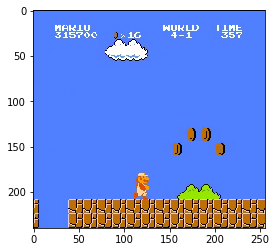

In [102]:
# read the image
frame = (mpimg.imread('frame.png')*255).astype(np.uint8)

# display image properties and image
print('This image is:', frame.dtype, type(frame), 'with dimensions:', frame.shape)
plt.imshow(frame) 

# Template matching
The goal of template matching is to find a **template** inside a larger image containing it. The basic idea of the method is to drag a template across an image, and compare the patch of the image with the template. Wherever the best match occurs, we'll have the template location.

For the demo, we are going to track Mario in a playthrough of Super Mario Bros. We'll start with finding Mario in an image to demonstrate the method, and then apply that same method to successive video frames.

The OpenCV template matching functions expect grayscale images, so the first step is to convert the image to grayscale.

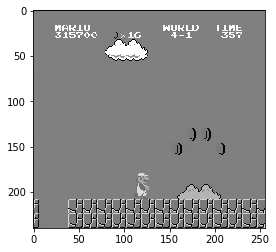

In [103]:
# convert image to grayscale
grayFrame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
plt.imshow(grayFrame, cmap='gray')

## Define the template
The next step for template matching is to define the template. And for this, we'll just use the image we've already loaded and just take a section of it.

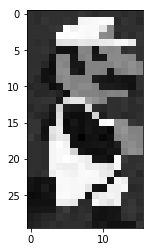

In [104]:
# Template is just a part of the original frame
mario = grayFrame[178:208,112:128]
plt.imshow(mario, cmap='gray')

# Find the template
Now that we have our template and image containing it, we can simply use the OpenCV function [`cv2.matchTemplate()`](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/object_detection.html#cv2.matchTemplate) to move our template through the image, and obtain a result showing the closeness of the match at each point. And then we'll grab the location of the minimum of that result, which will be closest match using [`cv2.minMaxLoc()`](http://docs.opencv.org/3.0-beta/modules/core/doc/operations_on_arrays.html#cv2.minMaxLoc) (as it's name suggests, it finds the min and max values and their locations).

Finally, we'll draw the location onto a copy of the original image with a yellow box to indicate where we've found the template using [`cv2.rectangle()`](http://docs.opencv.org/3.0-beta/modules/imgproc/doc/drawing_functions.html#cv2.rectangle).

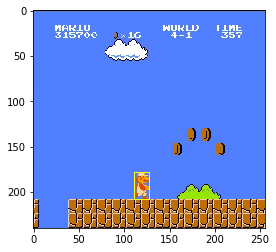

In [105]:
# find the template
ssd = cv2.matchTemplate(grayFrame, mario, method=cv2.TM_SQDIFF) # sum of square difference image
minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(ssd) # we care about the minLoc

# display the template
mh, mw = mario.shape # for the height and width of the box we're drawing
x, y = minLoc # minLoc is a point (x, y)
cv2.rectangle(frame, (x, y), (x+mw, y+mh), color=[255,255,0], thickness=1) # draw rectangle
plt.imshow(frame)

# Great! Now for the video...

We'll need to define a function which takes in a frame of the video and the template, locates the template, draws a box, and returns the modified frame.

In [106]:
def trackTemplate(frame, templ):
    
    # convert frame to grayscale
    grayFrame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    # match template
    ssd = cv2.matchTemplate(grayFrame, templ, method=cv2.TM_SQDIFF)
    minLoc = cv2.minMaxLoc(ssd)[2]

    # draw box around template location
    th, tw = templ.shape[:2] # for the height and width of the box we're drawing
    x, y = minLoc # minLoc is a point (x, y)
    cv2.rectangle(frame, (x, y), (x+tw, y+th), color=[255,255,0], thickness=1) # draw rectangle
    
    return frame

# Track the template in video

For simplifying Jupyter interactions, we'll use `moviepy` for reading, modifying, and writing video files. 

Note: The `fl_image()` method accepts a function as an input, and it sends the frame as a single input to the function. However, our method needs two inputs; so we'll define an anonymous function so that the second output gets sent.

### This will take a minute

In [107]:
outFile1 = "output1.mp4"
vid = VideoFileClip("smb.mp4")

# this function processes the frames. 
# Note: fl_image takes in a one parameter function as an argument and passes the frame to it.
#       To send a function with multiple arguments, create an inline anonymous function.
outVid1 = vid.fl_image(lambda frame: trackTemplate(frame, mario))

# write to file
%time outVid1.write_videofile(outFile1, audio=False)

[MoviePy] >>>> Building video output1.mp4
[MoviePy] Writing video output1.mp4


100%|██████████| 4124/4124 [00:09<00:00, 416.58it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output1.mp4 

CPU times: user 8.31 s, sys: 1.36 s, total: 9.67 s
Wall time: 9.95 s


# Viewing the result
We can display the video in-line on Jupyter with some HTML

In [108]:
HTML("""
<video src="{0}" controls />
""".format(outFile1))

# Improving results
One way to improve the results is to just use Mario's head as the template since it changes less than his body movements.

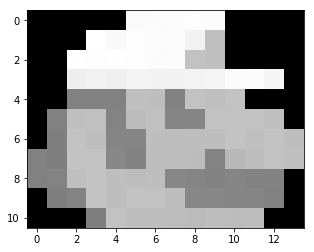

In [109]:
mario = mario[1:12,2:]
mask = np.array([
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
])
plt.imshow(mario*mask, cmap='gray')

In [110]:
def trackTemplate(frame, templ, mask):
    
    # convert frame to grayscale
    grayFrame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    # match template
    ssd = cv2.matchTemplate(grayFrame, templ, method=cv2.TM_SQDIFF, mask=mask)
    minLoc = cv2.minMaxLoc(ssd)[2]

    # draw box around template location
    th, tw = templ.shape[:2] # for the height and width of the box we're drawing
    x, y = minLoc # minLoc is a point (x, y)
    cv2.rectangle(frame, (x-1, y), (x+14, y+30), color=[255,255,0], thickness=1) # draw rectangle
    
    return frame

In [111]:
outFile2 = "output2.mp4"
vid = VideoFileClip("smb.mp4")
outVid2 = vid.fl_image(lambda frame: trackTemplate(frame, mario, mask))
%time outVid2.write_videofile(outFile2, audio=False)

[MoviePy] >>>> Building video output2.mp4
[MoviePy] Writing video output2.mp4


100%|██████████| 4124/4124 [00:22<00:00, 184.12it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output2.mp4 

CPU times: user 20.5 s, sys: 1.69 s, total: 22.2 s
Wall time: 22.4 s


In [99]:
HTML("""
<video src="{0}" controls />
""".format(outFile2))

# Further improvements

### Better matching
We can get better matching by using all three color channels instead of just a grayscale image. OpenCV's `matchTemplate()` only works with single-channel (i.e. grayscale) images, but we could run `matchTemplate()` on each channel of an RGB image, and then sum them to get the `ssd` result, and then proceed as before. This increases the computation time by a factor of three though, so some computational efficiencies would be good to add.

### Speed
This function is a little slow. It's not too bad for how small our image and template are, but on an HD video this would take ages. A big improvement can be had by reducing the search area. Since we know where Mario was in the last frame, we know he'll be around the same position in the next frame. So we can create a search area around the last location and not need to search the whole images.

### Off-screen Mario handling
A threshold could be defined on how well the template should match, so that when Mario is off-screen no box is drawn around any other objects.

# Example of all three additions
These additions gave me the solution I was looking for. This all started from a [reddit thread](https://www.reddit.com/r/computervision/comments/69p1bj/best_way_to_track_super_mario_in_recorded_video/). The video shows the search area around Mario's head, which grows when Mario wasn't found in the last frame. This uses a custom template matching function that I wrote (for no reason, it does the same thing as the OpenCV version), and runs on all three channels instead of just the grayscale.

In [117]:
HTML("""
<iframe width="560" height="315" 
    src="https://www.youtube.com/embed/m99H6oH46E8?ecver=1" 
    frameborder="0" allowfullscreen>
</iframe>""")